# Bicycle-stations Availability Prediction

Use a supervised machine learning algorithm to predict the availability for each bicyle-sharing stations in Lyon (France) based on the history data.

I use the tree method [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html) to predict a "probability" of bikes availability for each station. A number close to 1. means that you have several available bikes. A number close to 0. means you don't have many bikes.

## Some Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
from xgboost import plot_tree

/Users/babou/anaconda/envs/python3DS/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt

In [5]:
import folium

In [6]:
%load_ext watermark

In [7]:
%watermark -d -v -p numpy,pandas,xgboost,matplotlib,folium -g -m -w

2017-10-20 

CPython 3.5.3
IPython 6.1.0

numpy 1.13.1
pandas 0.20.3
xgboost 0.6
matplotlib 2.0.2
folium 0.5.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 5a6b6a327075a6b5682695e9e824de03fad1426c
watermark 1.5.0


The module `prediction.py` contains some functions dedicated to the bicyle-sharing stations predictions.

In [8]:
from prediction import (datareader, complete_data, cleanup, bikes_probability,
                        time_resampling, prepare_data_for_training, fit, prediction)

## Read and prepare the data

In [9]:
DATAFILE = './data/lyon.csv'

In [10]:
raw = datareader(DATAFILE)

2017-10-20 14:16:37,547 [84105] INFO     prediction: read the file './data/lyon.csv'


In [11]:
raw.head()

number         last_update  bike_stands  available_bike_stands  \
0   10063 2017-07-08 23:49:09           34                     10   
1   10021 2017-07-08 00:30:12           19                      0   
2    8038 2017-07-08 23:49:26           20                      6   
3    7045 2017-07-08 23:52:43           20                     13   
4    6045 2017-07-08 23:52:14           15                      7   

   available_bikes  availabilitycode availability bonus  status  
0               23                 1         Vert   Non    OPEN  
1                0                 0         Gris   Non  CLOSED  
2               14                 1         Vert   Non    OPEN  
3                7                 1         Vert   Non    OPEN  
4                8                 1         Vert   Non    OPEN

Min and max dates of the timeseries

In [12]:
print(raw.last_update.min())
print(raw.last_update.max())

2017-07-08 00:30:12
2017-09-26 14:58:46


Clean up some columns : drop some lines with the 'CLOSED' status, drop duplicates, remove missing values, etc.

In [13]:
df_clean = cleanup(raw)

2017-10-20 14:16:56,673 [84105] INFO     prediction: cleanup processing


Pipe some processing data functions :

* time resampling to get data every 10 minutes (i.e. `10T`)
* add some columns : day of the week, hour of the day, etc.
* compute the bikes (number) "probability". It's just a normalization for each station with `num_avail_bikes / total`

In [14]:
df = (df_clean.pipe(time_resampling)
      .pipe(complete_data)
      .pipe(bikes_probability))

2017-10-20 14:17:02,938 [84105] INFO     prediction: Time resampling for each station by '10T'
2017-10-20 14:17:07,602 [84105] INFO     prediction: complete some data
2017-10-20 14:17:59,126 [84105] INFO     prediction: bikes probability


In [15]:
df.head()

station                  ts  bikes  stands  day  hour  minute  probability
0     1001 2017-07-09 00:00:00   15.0     1.0    6     0       0      0.93750
1     1001 2017-07-09 00:10:00   15.0     1.0    6     0       0      0.93750
2     1001 2017-07-09 00:20:00   14.5     1.5    6     0      10      0.90625
3     1001 2017-07-09 00:30:00   14.5     1.5    6     0      20      0.90625
4     1001 2017-07-09 00:40:00   11.5     4.5    6     0      30      0.71875

This is the final dataset. For further prediction, I could add some weather forecasts data to these features.

## Prediction

Let's select a time window (start, stop) to a single prediction.

* Two weeks of data for training
* Predict the 'probability' for the next 30 minutes and 1 hour for every station.
* Split the dataset into train and test dataset
* Compute the RMSE (Root Mean Squared Error) between the observations (i.e. probability) and the predicted values

In [57]:
start = pd.Timestamp("2017-07-11T00:00:00") # Tuesday
predict_date = pd.Timestamp("2017-07-26T10:00:00") # wednesday
# predict the next 30 minutes
freq = '30T'
# number of predictions at 'predict_date'.
# Here, the next 30 minutes and the next hour (30 minutes + 30 minutes).
# If you want to predict the next 3 hours, every 30 minutes, thus set periods=6
periods = 2

In [58]:
train_X, train_Y, test_X, test_Y = prepare_data_for_training(df,
                                                             predict_date,
                                                             freq=freq,
                                                             start=start,
                                                             periods=periods,
                                                             observation='probability')

2017-10-20 14:32:34,790 [84105] INFO     prediction: prepare data for training
2017-10-20 14:32:34,792 [84105] INFO     prediction: sort values (station, ts)
2017-10-20 14:32:38,253 [84105] INFO     prediction: compute the future availability at '30T'
2017-10-20 14:32:39,090 [84105] INFO     prediction: merge data with the future availability
2017-10-20 14:33:32,569 [84105] INFO     prediction: availability label as values
2017-10-20 14:33:33,457 [84105] INFO     prediction: cut date 2017-07-26 09:30:00
2017-10-20 14:33:33,463 [84105] INFO     prediction: stop date 2017-07-26 11:00:00
2017-10-20 14:33:33,464 [84105] INFO     prediction: split train and test according to a prediction date


In [59]:
train_X[train_X.station == 1005].head(10)

station  bikes  stands  day  hour  minute
ts                                                            
2017-07-11 00:00:00     1005    1.0     9.0    1     0       0
2017-07-11 00:10:00     1005    1.0     9.0    1     0       0
2017-07-11 00:20:00     1005    1.0     9.0    1     0      10
2017-07-11 00:30:00     1005    1.0     9.0    1     0      20
2017-07-11 00:40:00     1005    1.0     9.0    1     0      30
2017-07-11 00:50:00     1005    1.0     9.0    1     0      40
2017-07-11 01:00:00     1005    1.0     9.0    1     1       0
2017-07-11 01:10:00     1005    1.0     9.0    1     1       0
2017-07-11 01:20:00     1005    1.0     9.0    1     1      10
2017-07-11 01:30:00     1005    2.0     8.0    1     1      20

In [65]:
#################
### Armand GILLES
### Features engi
#################

In [89]:
def create_shift_features(df, features_name, feature_to_shift, features_grp, nb_shift):
    """
    Genic function to create shift features
    """
    # Create shift features
    df[features_name] = df.groupby([features_grp])[feature_to_shift].shift(nb_shift)
    df[features_name] = df[features_name].fillna(method='bfill')
    return df

In [67]:
## Sorting training data on ts & station for shift temporal features
# Train
train_X['ts'] = train_X.index
train_X = train_X.sort_values(['station', 'ts'])
# Test
test_X['ts'] = test_X.index
test_X = test_X.sort_values(['station', 'ts'])

In [68]:
## Shift features
# On train
train_X = create_shift_features(train_X, features_name='bikes_shift_30min', feature_to_shift='bikes', 
                                features_grp='station', nb_shift=3)
# On test
test_X = create_shift_features(test_X, features_name='bikes_shift_30min', feature_to_shift='bikes', 
                               features_grp='station', nb_shift=3)

In [69]:
train_X[train_X.station == 1005].head(20)

station  bikes  stands  day  hour  minute  \
ts                                                               
2017-07-11 00:00:00     1005    1.0     9.0    1     0       0   
2017-07-11 00:10:00     1005    1.0     9.0    1     0       0   
2017-07-11 00:20:00     1005    1.0     9.0    1     0      10   
2017-07-11 00:30:00     1005    1.0     9.0    1     0      20   
2017-07-11 00:40:00     1005    1.0     9.0    1     0      30   
2017-07-11 00:50:00     1005    1.0     9.0    1     0      40   
2017-07-11 01:00:00     1005    1.0     9.0    1     1       0   
2017-07-11 01:10:00     1005    1.0     9.0    1     1       0   
2017-07-11 01:20:00     1005    1.0     9.0    1     1      10   
2017-07-11 01:30:00     1005    2.0     8.0    1     1      20   
2017-07-11 01:40:00     1005    3.0     7.0    1     1      30   
2017-07-11 01:50:00     1005    3.0     7.0    1     1      40   
2017-07-11 02:00:00     1005    3.0     7.0    1     2       0   
2017-07-11 02:10:00     1005    3.0     7.0    1     2       0   
2017-07-11 02:20:00     1005    3.0     7.0    1     2      10   
2017-07-11 02:30:00     1005    3.0     7.0    1     2      20   
2017-07-11 02:40:00     1005    3.0     7.0    1     2      30   
2017-07-11 02:50:00     1005    3.0     7.0    1     2      40   
2017-07-11 03:00:00     1005    3.0     7.0    1     3       0   
2017-07-11 03:10:00     1005    3.0     7.0    1     3       0   

                                     ts  bikes_shift_30min  
ts                                                          
2017-07-11 00:00:00 2017-07-11 00:00:00                1.0  
2017-07-11 00:10:00 2017-07-11 00:10:00                1.0  
2017-07-11 00:20:00 2017-07-11 00:20:00                1.0  
2017-07-11 00:30:00 2017-07-11 00:30:00                1.0  
2017-07-11 00:40:00 2017-07-11 00:40:00                1.0  
2017-07-11 00:50:00 2017-07-11 00:50:00                1.0  
2017-07-11 01:00:00 2017-07-11 01:00:00                1.0  
2017-07-11 01:10:00 2017-07-11 01:10:00                1.0  
2017-07-11 01:20:00 2017-07-11 01:20:00                1.0  
2017-07-11 01:30:00 2017-07-11 01:30:00                1.0  
2017-07-11 01:40:00 2017-07-11 01:40:00                1.0  
2017-07-11 01:50:00 2017-07-11 01:50:00                1.0  
2017-07-11 02:00:00 2017-07-11 02:00:00                2.0  
2017-07-11 02:10:00 2017-07-11 02:10:00                3.0  
2017-07-11 02:20:00 2017-07-11 02:20:00                3.0  
2017-07-11 02:30:00 2017-07-11 02:30:00                3.0  
2017-07-11 02:40:00 2017-07-11 02:40:00                3.0  
2017-07-11 02:50:00 2017-07-11 02:50:00                3.0  
2017-07-11 03:00:00 2017-07-11 03:00:00                3.0  
2017-07-11 03:10:00 2017-07-11 03:10:00                3.0

In [70]:
## Create feature on trend
## Counting number of cumulative trending
## If there are 5 cumulative row with no change on bikes number then 5 for 'cumsum_trend_equal'
# Train
train_X['bool_trend_sup'] = 0
train_X.loc[train_X['bikes'] > train_X['bikes_shift_30min'], 'bool_trend_sup'] = 1
train_X['bool_trend_inf'] = 0
train_X.loc[train_X['bikes'] < train_X['bikes_shift_30min'], 'bool_trend_inf'] = 1
train_X['bool_trend_equal'] = 0
train_X.loc[train_X['bikes'] == train_X['bikes_shift_30min'], 'bool_trend_equal'] = 1

# Test
test_X['bool_trend_sup'] = 0
test_X.loc[test_X['bikes'] > test_X['bikes_shift_30min'], 'bool_trend_sup'] = 1
test_X['bool_trend_inf'] = 0
test_X.loc[test_X['bikes'] < test_X['bikes_shift_30min'], 'bool_trend_inf'] = 1
test_X['bool_trend_equal'] = 0
test_X.loc[test_X['bikes'] == test_X['bikes_shift_30min'], 'bool_trend_equal'] = 1

# Resorting to cumsum
# Resort value as prepare_data_for_training
train_X = train_X.sort_values(['station', 'ts'])
#train_X = train_X.drop('ts', axis=1)
test_X = test_X.sort_values(['station', 'ts'])
#test_X = test_X.drop('ts', axis=1)


train_X['cumsum_trend_sup'] = train_X["bool_trend_sup"].groupby((train_X["bool_trend_sup"] == 0).cumsum()).cumcount()
train_X['cumsum_trend_inf'] = train_X["bool_trend_inf"].groupby((train_X["bool_trend_inf"] == 0).cumsum()).cumcount()
train_X['cumsum_trend_equal'] = train_X["bool_trend_equal"].groupby((train_X["bool_trend_equal"] == 0).cumsum()).cumcount()

test_X['cumsum_trend_sup'] = test_X["bool_trend_sup"].groupby((test_X["bool_trend_sup"] == 0).cumsum()).cumcount()
test_X['cumsum_trend_inf'] = test_X["bool_trend_inf"].groupby((test_X["bool_trend_inf"] == 0).cumsum()).cumcount()
test_X['cumsum_trend_equal'] = test_X["bool_trend_equal"].groupby((test_X["bool_trend_equal"] == 0).cumsum()).cumcount()

In [74]:
train_X[train_X.stationion == 1005].head(25)

station  bikes  stands  day  hour  minute  \
ts                                                               
2017-07-11 00:00:00     1005    1.0     9.0    1     0       0   
2017-07-11 00:10:00     1005    1.0     9.0    1     0       0   
2017-07-11 00:20:00     1005    1.0     9.0    1     0      10   
2017-07-11 00:30:00     1005    1.0     9.0    1     0      20   
2017-07-11 00:40:00     1005    1.0     9.0    1     0      30   
2017-07-11 00:50:00     1005    1.0     9.0    1     0      40   
2017-07-11 01:00:00     1005    1.0     9.0    1     1       0   
2017-07-11 01:10:00     1005    1.0     9.0    1     1       0   
2017-07-11 01:20:00     1005    1.0     9.0    1     1      10   
2017-07-11 01:30:00     1005    2.0     8.0    1     1      20   
2017-07-11 01:40:00     1005    3.0     7.0    1     1      30   
2017-07-11 01:50:00     1005    3.0     7.0    1     1      40   
2017-07-11 02:00:00     1005    3.0     7.0    1     2       0   
2017-07-11 02:10:00     1005    3.0     7.0    1     2       0   
2017-07-11 02:20:00     1005    3.0     7.0    1     2      10   
2017-07-11 02:30:00     1005    3.0     7.0    1     2      20   
2017-07-11 02:40:00     1005    3.0     7.0    1     2      30   
2017-07-11 02:50:00     1005    3.0     7.0    1     2      40   
2017-07-11 03:00:00     1005    3.0     7.0    1     3       0   
2017-07-11 03:10:00     1005    3.0     7.0    1     3       0   
2017-07-11 03:20:00     1005    3.0     7.0    1     3      10   
2017-07-11 03:30:00     1005    3.0     7.0    1     3      20   
2017-07-11 03:40:00     1005    3.0     7.0    1     3      30   
2017-07-11 03:50:00     1005    3.0     7.0    1     3      40   
2017-07-11 04:00:00     1005    3.0     7.0    1     4       0   

                                     ts  bikes_shift_30min  cumsum_trend_sup  \
ts                                                                             
2017-07-11 00:00:00 2017-07-11 00:00:00                1.0                 0   
2017-07-11 00:10:00 2017-07-11 00:10:00                1.0                 0   
2017-07-11 00:20:00 2017-07-11 00:20:00                1.0                 0   
2017-07-11 00:30:00 2017-07-11 00:30:00                1.0                 0   
2017-07-11 00:40:00 2017-07-11 00:40:00                1.0                 0   
2017-07-11 00:50:00 2017-07-11 00:50:00                1.0                 0   
2017-07-11 01:00:00 2017-07-11 01:00:00                1.0                 0   
2017-07-11 01:10:00 2017-07-11 01:10:00                1.0                 0   
2017-07-11 01:20:00 2017-07-11 01:20:00                1.0                 0   
2017-07-11 01:30:00 2017-07-11 01:30:00                1.0                 1   
2017-07-11 01:40:00 2017-07-11 01:40:00                1.0                 2   
2017-07-11 01:50:00 2017-07-11 01:50:00                1.0                 3   
2017-07-11 02:00:00 2017-07-11 02:00:00                2.0                 4   
2017-07-11 02:10:00 2017-07-11 02:10:00                3.0                 0   
2017-07-11 02:20:00 2017-07-11 02:20:00                3.0                 0   
2017-07-11 02:30:00 2017-07-11 02:30:00                3.0                 0   
2017-07-11 02:40:00 2017-07-11 02:40:00                3.0                 0   
2017-07-11 02:50:00 2017-07-11 02:50:00                3.0                 0   
2017-07-11 03:00:00 2017-07-11 03:00:00                3.0                 0   
2017-07-11 03:10:00 2017-07-11 03:10:00                3.0                 0   
2017-07-11 03:20:00 2017-07-11 03:20:00                3.0                 0   
2017-07-11 03:30:00 2017-07-11 03:30:00                3.0                 0   
2017-07-11 03:40:00 2017-07-11 03:40:00                3.0                 0   
2017-07-11 03:50:00 2017-07-11 03:50:00                3.0                 0   
2017-07-11 04:00:00 2017-07-11 04:00:00                3.0                 0   

                     cumsum_trend_inf  cumsum_trend_equal  
ts               

In [72]:
# Delete non usefull features
train_X.drop(['bool_trend_sup', 'bool_trend_inf', 'bool_trend_equal'], axis=1, inplace=True)
test_X.drop(['bool_trend_sup', 'bool_trend_inf', 'bool_trend_equal'], axis=1, inplace=True)

In [75]:
# Resort value as prepare_data_for_training
train_X = train_X.sort_values(['ts', 'station'])
train_X = train_X.drop('ts', axis=1)
test_X = test_X.sort_values(['ts', 'station'])
test_X = test_X.drop('ts', axis=1)

In [76]:
# Observation with a shift of T+30 minutes in comparison to train_X.
# This is the 'future' availability used for traning.
train_Y.head()

ts
2017-07-11    0.923077
2017-07-11    0.295455
2017-07-11    0.933333
2017-07-11    0.100000
2017-07-11    0.227273
Name: future, dtype: float64

In [77]:
train_X.head()

station  bikes  stands  day  hour  minute  bikes_shift_30min  \
ts                                                                         
2017-07-11     1001   12.0     1.0    1     0       0               12.0   
2017-07-11     1002    6.0    15.5    1     0       0                6.0   
2017-07-11     1003   14.0     1.0    1     0       0               14.0   
2017-07-11     1005    1.0     9.0    1     0       0                1.0   
2017-07-11     1006    4.5    17.5    1     0       0                4.5   

            cumsum_trend_sup  cumsum_trend_inf  cumsum_trend_equal  
ts                                                                  
2017-07-11                 0                 0                   0  
2017-07-11                 0                 0                   1  
2017-07-11                 0                 0                   1  
2017-07-11                 0                 0                   1  
2017-07-11                 0                 0                   4

The `fit` function create some data structure for the XGBoost from the train and test DataFrames (i.e. `xgb.DMatrix)`, configure the model and launch it with the `objective: 'reg:logistic'`. It's a regression, not a classification.

In [79]:
# the 'booster'
param ={"objective": "reg:logistic",
          "booster" : "gbtree",
          "eta": 0.2,
          "max_depth": 8,
          "silent": 1,
          "seed": 42}
bst = fit(train_X, train_Y, test_X, test_Y, param)

2017-10-20 14:36:53,873 [84105] INFO     prediction: fit


[0]	train-rmse:0.27047	test-rmse:0.268447
[1]	train-rmse:0.225046	test-rmse:0.223612
[2]	train-rmse:0.19014	test-rmse:0.189224
[3]	train-rmse:0.163544	test-rmse:0.163131
[4]	train-rmse:0.143515	test-rmse:0.143343
[5]	train-rmse:0.12872	test-rmse:0.128746
[6]	train-rmse:0.118012	test-rmse:0.118097
[7]	train-rmse:0.110374	test-rmse:0.110544
[8]	train-rmse:0.105048	test-rmse:0.105112
[9]	train-rmse:0.101377	test-rmse:0.101483
[10]	train-rmse:0.098862	test-rmse:0.098921
[11]	train-rmse:0.097115	test-rmse:0.097156
[12]	train-rmse:0.095933	test-rmse:0.095929
[13]	train-rmse:0.095101	test-rmse:0.09508
[14]	train-rmse:0.094504	test-rmse:0.094463
[15]	train-rmse:0.094037	test-rmse:0.094015
[16]	train-rmse:0.093722	test-rmse:0.093779
[17]	train-rmse:0.093446	test-rmse:0.093528
[18]	train-rmse:0.093176	test-rmse:0.093375
[19]	train-rmse:0.092969	test-rmse:0.093211
[20]	train-rmse:0.09279	test-rmse:0.093121
[21]	train-rmse:0.092637	test-rmse:0.092964
[22]	train-rmse:0.092499	test-rmse:0.092893
[23

In [83]:
#0.092800 original
#0.092739 shift 30 min
#0.092987 shift 30 min + trend cum
#0.092723 shift 30 min + trend cum max_depth : 8
# compute the prediction from test_*
pred = prediction(bst, test_X, test_Y)

In [84]:
pred[:5]

array([ 0.13832611,  0.34632099,  0.12407598,  0.24013656,  0.11466357], dtype=float32)

In [85]:
print("Number of predictions: {}".format(len(pred)))

Number of predictions: 2359


In [86]:
# Compute the RMSE
rmse = np.sqrt(np.mean((pred - test_Y)**2))
rmse

0.092723348295373056

In [45]:
# must install graphviz
# plot_tree(bst)

## Store the results

In [87]:
result = test_X.copy()
result['ts_future'] = test_Y.index.shift(1, freq=freq)

result['observation'] = test_Y.copy()
result['ts_future'] = test_Y.index.shift(1, freq=freq) ##??
result['prediction'] = pred
result['error'] = pred - test_Y
result['relative_error'] = 100. * np.abs(pred - test_Y) / test_Y
result['quad_error'] = (pred - test_Y)**2
result.to_csv("prediction-freq-{}-{}.csv".format(freq, predict_date))

In [88]:
result.head(10)

station  bikes  stands  day  hour  minute  \
ts                                                               
2017-07-26 10:00:00     1001    2.0    14.0    2    10       0   
2017-07-26 10:00:00     1002    8.0    14.0    2    10       0   
2017-07-26 10:00:00     1003    2.0    13.0    2    10       0   
2017-07-26 10:00:00     1005    2.0     8.0    2    10       0   
2017-07-26 10:00:00     1006    2.0    19.0    2    10       0   
2017-07-26 10:00:00     1012   16.0     4.0    2    10       0   
2017-07-26 10:00:00     1013    3.0     8.0    2    10       0   
2017-07-26 10:00:00     1016    2.0    15.0    2    10       0   
2017-07-26 10:00:00     1020    1.0    17.0    2    10       0   
2017-07-26 10:00:00     1021    7.0     4.0    2    10       0   

                     bikes_shift_30min  cumsum_trend_sup  cumsum_trend_inf  \
ts                                                                           
2017-07-26 10:00:00                2.0                 0                 0   
2017-07-26 10:00:00                8.0                 0                 0   
2017-07-26 10:00:00                2.0                 0                 0   
2017-07-26 10:00:00                2.0                 0                 0   
2017-07-26 10:00:00                2.0                 0                 0   
2017-07-26 10:00:00               16.0                 0                 0   
2017-07-26 10:00:00                3.0                 0                 0   
2017-07-26 10:00:00                2.0                 0                 0   
2017-07-26 10:00:00                1.0                 0                 0   
2017-07-26 10:00:00                7.0                 0                 0   

                     cumsum_trend_equal           ts_future  observation  \
ts                                                                         
2017-07-26 10:00:00                   0 2017-07-26 10:30:00     0.375000   
2017-07-26 10:00:00                   2 2017-07-26 10:30:00     0.255814   
2017-07-26 10:00:00                   3 2017-07-26 10:30:00     0.133333   
2017-07-26 10:00:00                   1 2017-07-26 10:30:00     0.300000   
2017-07-26 10:00:00                   1 2017-07-26 10:30:00     0.047619   
2017-07-26 10:00:00                   1 2017-07-26 10:30:00     0.850000   
2017-07-26 10:00:00                   1 2017-07-26 10:30:00     0.181818   
2017-07-26 10:00:00                   2 2017-07-26 10:30:00     0.147059   
2017-07-26 10:00:00                   1 2017-07-26 10:30:00     0.055556   
2017-07-26 10:00:00                   1 2017-07-26 10:30:00     0.909091   

                     prediction     error  relative_error  quad_error  
ts                                                                     
2017-07-26 10:00:00    0.138326 -0.236674       63.113038    0.056015  
2017-07-26 10:00:00    0.346321  0.090507       35.380022    0.008192  
2017-07-26 10:00:00    0.124076 -0.009257        6.943016    0.000086  
2017-07-26 10:00:00    0.240137 -0.059863       19.954479    0.003584  
2017-07-26 10:00:00    0.114664  0.067045      140.793499    0.004495  
2017-07-26 10:00:00    0.782310 -0.067690        7.963584    0.004582  
2017-07-26 10:00:00    0.294256  0.112438       61.840801    0.012642  
2017-07-26 10:00:00    0.118204 -0.028855       19.621125    0.000833  
2017-07-26 10:00:00    0.092565  0.037009       66.616464    0.001370  
2017-07-26 10:00:00    0.628197 -0.280894       30.898315    0.078901

## Some maps

CSV file with station coordinates

In [48]:
locations = pd.read_csv("./data/lyon-stations.csv")

In [49]:
locations.shape

(348, 4)

Some stations were removed when the data were cleaned up. Remove them from the location data.

In [50]:
mask = locations['idstation'].isin(result.station.unique())

In [51]:
mask.sum()

337

In [52]:
locations = locations[mask]

In [53]:
locations = locations.rename_axis({'idstation': 'station'}, axis=1)

In [54]:
locations.head()

station                       nom        lat       lon
0    10027    Mairie de Villeurbanne  45.766831  4.879894
1    10030                    Greuze  45.773844  4.893848
2    10034                       MJC  45.761788  4.886157
3    10036       Chaplin / Dutriévoz  45.774357  4.859155
4    10038  Condorcet / 11 Nov. 1918  45.779046  4.866778

Some station names contains the `'` character. Replace it by the HTML code for folium.

In [78]:
locations["nom"] = locations['nom'].str.replace("'", "&apos;")

Select the prediction data for a specific timestamp

In [79]:
data_to_plot = result.loc[predict_date]

In [80]:
data_to_plot.shape

(337, 12)

In [81]:
data_to_plot.head()

station  bikes  stands  day  hour  minute  \
ts                                                               
2017-07-26 10:00:00     1001    2.0    14.0    2    10       0   
2017-07-26 10:00:00     1002    8.0    14.0    2    10       0   
2017-07-26 10:00:00     1003    2.0    13.0    2    10       0   
2017-07-26 10:00:00     1005    2.0     8.0    2    10       0   
2017-07-26 10:00:00     1006    2.0    19.0    2    10       0   

                              ts_future  observation  prediction     error  \
ts                                                                           
2017-07-26 10:00:00 2017-07-26 10:30:00     0.375000    0.140736 -0.234264   
2017-07-26 10:00:00 2017-07-26 10:30:00     0.255814    0.358517  0.102703   
2017-07-26 10:00:00 2017-07-26 10:30:00     0.133333    0.145994  0.012661   
2017-07-26 10:00:00 2017-07-26 10:30:00     0.300000    0.227014 -0.072986   
2017-07-26 10:00:00 2017-07-26 10:30:00     0.047619    0.109391  0.061772   

                     relative_error  quad_error  
ts                                               
2017-07-26 10:00:00       62.470392    0.054880  
2017-07-26 10:00:00       40.147679    0.010548  
2017-07-26 10:00:00        9.495718    0.000160  
2017-07-26 10:00:00       24.328576    0.005327  
2017-07-26 10:00:00      129.721656    0.003816

In [83]:
yhat = data_to_plot[['station', 'prediction']].merge(locations, on='station')
yhat.head()

station  prediction               nom        lat       lon
0     1001    0.140736  Terreaux / Terme  45.767735  4.832135
1     1002    0.358517             Opéra  45.767507  4.836282
2     1003    0.145994    Place Sathonay  45.769266  4.830080
3     1005    0.227014        Meissonier  45.766089  4.832890
4     1006    0.109391      Subsistances  45.767896  4.819817

In [104]:
y = data_to_plot[['station', 'observation']].merge(locations, on='station')

In [140]:
error = data_to_plot[['station', 'error']].merge(locations, on='station')

In [122]:
colormap = 'RdYlBu'
cmap = plt.get_cmap(colormap)

See 

* https://matplotlib.org/examples/color/colormaps_reference.html
* https://matplotlib.org/api/colors_api.html

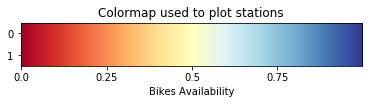

In [137]:
# show the colormap use to plot the stations, values [0, 1]
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots(1)
fig.subplots_adjust(top=0.95, bottom=0.80, left=0.2, right=0.99)
ax.set_xticks([0., 64, 128, 192, 256])
ax.set_xticklabels([0., 0.25, 0.5, 0.75, 1.])
ax.set_xlabel('Bikes Availability')
ax.imshow(gradient, aspect='auto', cmap=cmap, vmin=0, vmax=1)
plt.title('Colormap used to plot stations')

* Red stations if there are 0 or a few available bikes
* Blue stations if there are several available bikes

In [95]:
color = lambda x: mpl.colors.to_hex(cmap(x))

In [89]:
# Lyon (France) Position
position = [45.750000, 4.850000]

In [106]:
mp_pred = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [107]:
# Map of the predicted values
for _,row in yhat.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color(row['prediction']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color(row['prediction'])
    ).add_to(mp_pred)

In [102]:
mp_pred

In [108]:
# Map for the observation
mp_obs = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [109]:
# Map of the observations
for _,row in y.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color(row['observation']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color(row['observation'])
    ).add_to(mp_obs)

In [138]:
mp_obs

In [153]:
# Colormap for error (by default, the color map fits for [0, 1] values)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
color_error = lambda x: mpl.colors.to_hex(cmap(norm(x)))

In [154]:
# Map for the errors
mp_error = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [155]:
# Map of the errors
for _,row in error.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color_error(row['error']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color_error(row['error'])
    ).add_to(mp_error)

In [156]:
mp_error